In [ ]:
import cv2 as cv
import albumentations as A
import os
import sys
import datetime
import io

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Input,
    BatchNormalization,
    Layer,
    InputLayer,
    Dropout,
    Resizing,
    Rescaling,
    RandomFlip,
    RandomRotation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import (
    CategoricalAccuracy,
    TopKCategoricalAccuracy,
)
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

# from google.colab import drive
# drive.mount('/content/drive')
# TRAIN_DIR = "/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/train"
# TEST_DIR = "/content/drive/MyDrive/tfds_data/datasets/Emotions Dataset/Emotions Dataset/test"

TRAIN_DIR = "./datasets/Emotions Dataset/Emotions Dataset/train"
TEST_DIR = "./datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]  # This needs to be in accord with dir names.

CONFIG = {
    "batch_size": 32,
    "im_shape": (256, 256),
    "im_size": 256,
    "input_shape": (None, None, 3),
    "filters_1": 6,
    "filters_2": 16,
    "kernel_size": 3,
    "activation_1": "relu",
    "activation_2": "softmax",
    "dropout": 0.01,
    # "dropout": 0.00,
    "regularization_l2": 0.1,
    # "regularization_l2": 0.0,
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "pool_size": 2,
    "strides_1": 1,
    "strides_2": 2,
    "dense_1": 32,
    "dense_2": 32,
    "dense_3": 32,
    "dense_out": 3,
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 20,
}

In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    # NOTE: int -> 0 | 1 | 2; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
)

Found 6799 files belonging to 3 classes.


I0000 00:00:1730997064.709303     578 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2865 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 2278 files belonging to 3 classes.


# Transfer Learning

In [6]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False, # We don't want the Classifier part, only the Feature Extractor
    weights="imagenet",
    input_shape=(CONFIG["im_size"], CONFIG["im_size"], 3),
)
backbone.trainable = False

In [14]:
transfer_learning_model = tf.keras.Sequential([
    Input(shape=(CONFIG["im_size"], CONFIG["im_size"], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dense(128, activation="relu"),
    Dense(len(CLASS_NAMES), activation="softmax"),
])

transfer_learning_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [15]:
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "transfer_learning.weights.h5",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    initial_value_threshold=None,
)

transfer_learning_model.compile(
    optimizer=Adam(learning_rate=CONFIG["learning_rate"]*10),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=metrics,
)

In [ ]:
history = transfer_learning_model.fit(
    train_dataset.take(10), # Simulating small dataset (for thats the purpose of transfer learning)
    validation_data=test_dataset,
    epochs=CONFIG["epochs"],
    verbose=1,
    callbacks=[model_checkpoint],
)

In [19]:
transfer_learning_model.load_weights("transfer_learning.weights.h5")

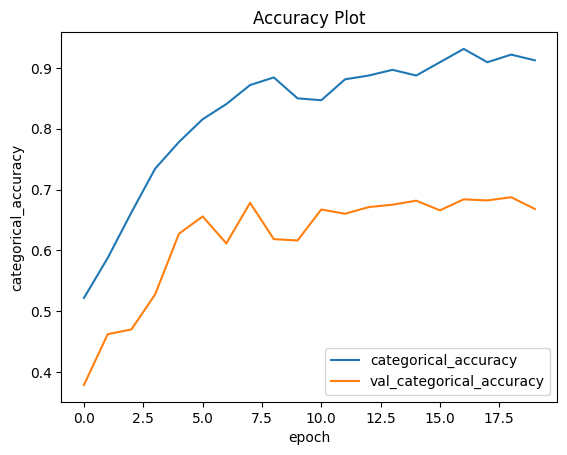

In [21]:
plt.figure()
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.legend(["categorical_accuracy", "val_categorical_accuracy"])
plt.title("Accuracy Plot")
plt.xlabel("epoch")
plt.ylabel("categorical_accuracy")
plt.show()

2024-11-07 13:13:20.486275: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


72
72
2278
2278


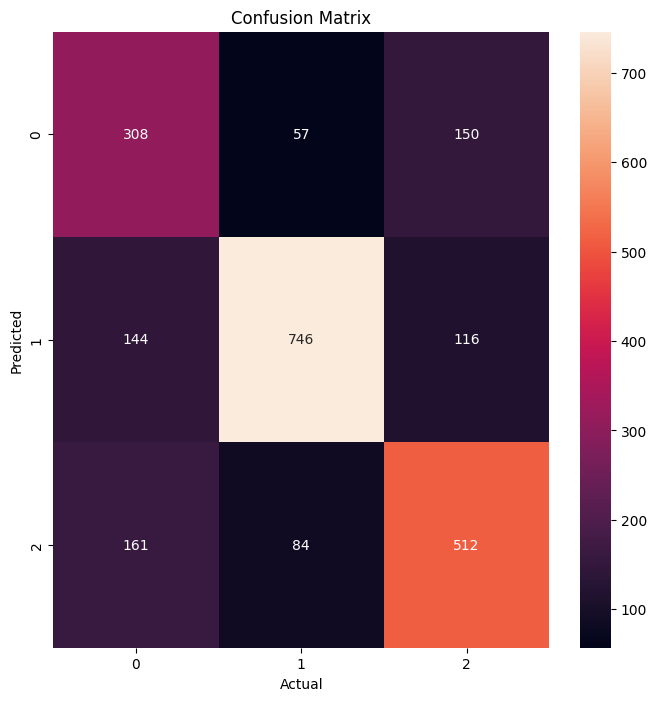

In [22]:
labels_true = []
predicted = []

model = transfer_learning_model

for images, labels in test_dataset:
    predicted.append(tf.math.argmax(model.predict(images, verbose=0), axis=-1))
    labels_true.append(tf.math.argmax(labels, axis=-1))

print(len(labels_true))
print(len(predicted))

# NOTE: I think you could just use test_dataset.unbatch() in the `for` above instead.
# We need to do this because the last batch not necessarely has 32 items.
# And because it doesn't have the same shape as the others, it cannot be fed
# directly to the confusion matrix.
labels_true = np.concatenate(
    [
        # Using tf.reshape to flatten.
        tf.reshape(labels_true[:-1], shape=[-1]),
        tf.reshape(labels_true[-1], shape=[-1]),  # last batch
    ]
)
predicted = np.concatenate(
    [
        tf.reshape(predicted[:-1], shape=[-1]),
        tf.reshape(predicted[-1], shape=[-1]),  # last batch
    ]
)

print(len(labels_true))
print(len(predicted))

cm = confusion_matrix(labels_true, predicted)

plt.figure(figsize=[8, 8])
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# Fine Tuning

In [3]:
backbone = tf.keras.applications.EfficientNetB4(
    include_top=False, # We don't want the Classifier part, only the Feature Extractor
    weights="imagenet",
    input_shape=(CONFIG["im_size"], CONFIG["im_size"], 3),
)
backbone.trainable = True # True for fine tuning, False for transfer learning.

In [4]:
input = Input(shape=(CONFIG["im_size"], CONFIG["im_size"], 3))
# training=False because of the internal BatchNormalization. It will use a moving average of mean and variance.
x = backbone(input, training=False) 
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(CLASS_NAMES), activation="softmax")(x)
ft_model = Model(input, output)

ft_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 8, 8, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 19,518,283 (74.46 MB)

 Non-trainable params: 127,255 (497.09 KB)

In [5]:
metrics = [CategoricalAccuracy(name="categorical_accuracy"), TopKCategoricalAccuracy(k=2)]

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "fine_tuning.weights.h5",
    monitor="val_categorical_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    initial_value_threshold=None,
)

ft_model.compile(
    # Remember to use a low LR in order to not disrupt the pre-trained weights of the backbone during fine tuning.
    optimizer=Adam(learning_rate=CONFIG["learning_rate"]),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=metrics,
)

In [6]:
ft_model.fit(train_dataset, validation_data=test_dataset, epochs=CONFIG["epochs"], verbose=1, callbacks=[model_checkpoint])

Epoch 1/20


I0000 00:00:1730997142.788060     786 service.cc:148] XLA service 0x7fd568004dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730997142.788976     786 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-11-07 13:32:25.470466: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730997153.328873     786 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-07 13:32:54.240023: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-07 13:32:54.966265: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/albert/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/albert/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/albert/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/albert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/albert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/albert/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/albert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/albert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/albert/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_578/1662438326.py", line 1, in <module>

  File "/home/albert/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/albert/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/albert/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 3715572128 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_97526]

In [ ]:
ft_model.load_weights("fine_tuning.weights.h5")

In [ ]:
plt.figure()
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.legend(["categorical_accuracy", "val_categorical_accuracy"])
plt.title("Accuracy Plot")
plt.xlabel("epoch")
plt.ylabel("categorical_accuracy")
plt.show()

In [ ]:
labels_true = []
predicted = []

model = transfer_learning_model

for images, labels in test_dataset:
    predicted.append(tf.math.argmax(model.predict(images, verbose=0), axis=-1))
    labels_true.append(tf.math.argmax(labels, axis=-1))

print(len(labels_true))
print(len(predicted))

# NOTE: I think you could just use test_dataset.unbatch() in the `for` above instead.
# We need to do this because the last batch not necessarely has 32 items.
# And because it doesn't have the same shape as the others, it cannot be fed
# directly to the confusion matrix.
labels_true = np.concatenate(
    [
        # Using tf.reshape to flatten.
        tf.reshape(labels_true[:-1], shape=[-1]),
        tf.reshape(labels_true[-1], shape=[-1]),  # last batch
    ]
)
predicted = np.concatenate(
    [
        tf.reshape(predicted[:-1], shape=[-1]),
        tf.reshape(predicted[-1], shape=[-1]),  # last batch
    ]
)

print(len(labels_true))
print(len(predicted))

cm = confusion_matrix(labels_true, predicted)

plt.figure(figsize=[8, 8])
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()